In [1]:
import cv2
import scipy
import skimage
import time

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
import SimpleITK as sitk

from scipy import sparse

from numba import vectorize, guvectorize, float32, int32, jit, cuda 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import math
from scipy import signal
from scipy.stats import entropy
from sklearn.cluster import KMeans # USAR EL DE RAPIDS

from typing import Optional

# from utils import pixel_graph, gaussian_kernel, region_extractor

In [4]:
def ns_mapper_using_complements(g: np.ndarray, max_iterations: int = 10):
    """
    Obtain the T and I matrices of the image g (one slice of the oct_scan)
    """
    # Step 2
    g_comp = 255 - g
    T = np.zeros(g_comp.shape)
    g_comp_min = np.min(g_comp)
    g_comp_max = np.max(g_comp)
    T = 1 - (g_comp - g_comp_min)/(g_comp_max - g_comp_min)
    
    # Step 3
    kernel = gaussian_kernel((3,9),1)
    
    # Steps 4,5, 6
    for it in range(max_iterations):
        I = np.zeros((T.shape))
        Ind = np.zeros((T.shape))
        FI = np.zeros((10, T.shape[0], T.shape[1]))
        for j in range(0,10):                                             # Step 5
            rotated_kernel = scipy.ndimage.rotate(kernel, 18*j, reshape=True)   # Step 4
            FI[j,:,:] = cv2.filter2D(T, -1, rotated_kernel)
        T_FI_abs_dif = np.abs(np.repeat(np.expand_dims(T,0),10,0) - FI)
        I = np.min(T_FI_abs_dif, axis=0)                                  # Step 6
        Ind = np.argmax(T_FI_abs_dif, axis=0)

        # Step 7 and 8
        idx = Ind[I >= 0.7]
        T[I >= 0.7] = FI[idx,I >= 0.7]
        
        # Step 9
        entropy = 0 if it==0 else entropy
        entropy_dif = np.abs(scipy.stats.entropy(I.flatten()) - entropy)
        if entropy_dif < 0.001:
            return T, I
        else:
            entropy = scipy.stats.entropy(I.flatten())
    print('Retourned by iterations')
    return T, I

### Comparing both NS mappers 

Si se usa tal cual como está en el paper la imágen que resulta (T_si_comp) no coincide con lo que se muestra

In [5]:
# from utils import pixel_graph, gaussian_kernel, region_extractor, rashno_ns_mapper

# itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/TRAIN025/oct.mhd')
# ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/TRAIN025/reference.mhd')

# oct_scan = sitk.GetArrayFromImage(itkimage)
# ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)
# g = oct_scan[20,:,:].copy()

# # Get the NS tranform
# T_no_comp, I_no_comp = rashno_ns_mapper(g)
# T_si_comp, I_si_comp = ns_mapper_using_complements(g, 10)
# T_comp = skimage.util.invert(T_si_comp)

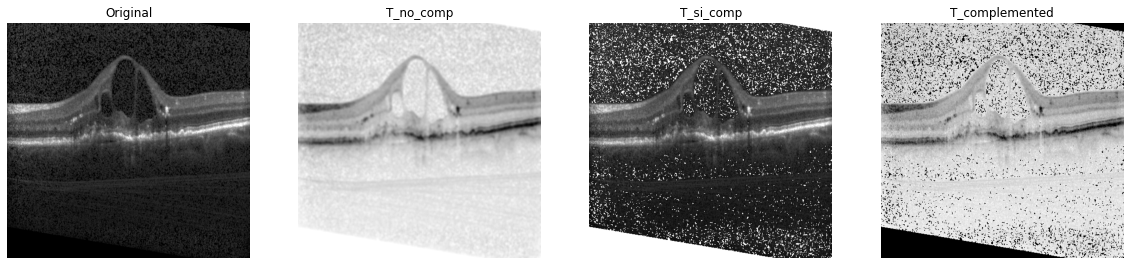

In [6]:
# plt.figure(figsize=(20,10))
# plt.subplot(1,4,1)
# plt.title('Original')
# plt.imshow(g, cmap='gray')
# plt.axis('off')
# plt.subplot(1,4,2)
# plt.title('T_no_comp')
# plt.imshow(T_no_comp, cmap='gray')
# plt.axis('off')
# plt.subplot(1,4,3)
# plt.title('T_si_comp')
# plt.imshow(T_si_comp, cmap='gray')
# plt.axis('off')
# plt.subplot(1,4,4)
# plt.title('T_complemented')
# plt.imshow(T_comp, cmap='gray')
# plt.axis('off')
# plt.show()

La que más se parece a la imagen del paper es la que usa el complemento adentro y complementarlo luego. Ese ultimo paso no aparece en el paper

### Proto pipeline

In [11]:
def preprocessing(manufacturer: str, im: np.ndarray, ref: np.ndarray):
    im, ref = region_extractor(manufacturer, im, ref)
    
    spacing = itkimage.GetSpacing()
    im = scipy.ndimage.zoom(im, (1, spacing[0]/spacing[1]), order=3, mode='reflect', prefilter=False)
    ref = scipy.ndimage.zoom(ref, (1, spacing[0]/spacing[1]), order=0, mode='reflect', prefilter=False)
    if manufacturer=='Spectralis':
        cv2.normalize(im, im, 0, 255, cv2.NORM_MINMAX)
        im = im.astype('uint8')
        im = cv2.bilateralFilter(src=im, d=10, sigmaColor=200, sigmaSpace=2)
        
    return im, ref

In [16]:
def plots(im, ref, ilm_image, rpe_image, retina_mask):
    plt.figure(figsize=(20,5))

    plt.subplot(2,2,2)
    plt.title('Original')
    plt.imshow(im, cmap='gray')
    plt.imshow(ref, alpha=0.4)
#     plt.axis('off')

    plt.subplot(2,2,1)
    plt.title('ILM')
    plt.imshow(im, cmap='gray')
    plt.imshow(ilm_image, alpha=0.8)
    plt.axis('off')

    plt.subplot(2,2,3)
    plt.title('RPE')
    plt.imshow(im, cmap='gray')
    plt.imshow(rpe_image, alpha=0.8)
    plt.axis('off')

    plt.subplot(2,2,4)
    plt.title('region')
    plt.imshow(im, cmap='gray')
    plt.imshow(retina_mask, alpha=0.6)
    plt.axis('off')
    plt.show()

In [21]:
from utils import (
    pixel_graph, gaussian_kernel, region_extractor, rashno_ns_mapper,
    get_ilm_line, get_rpe_line, rpe_flattening, get_retina_mask
)


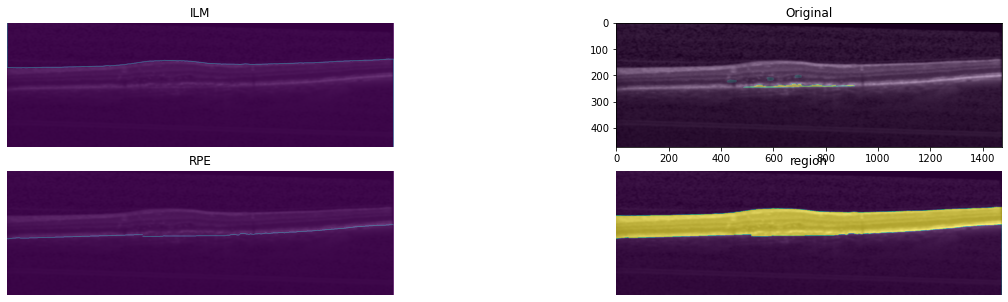

In [24]:
# Image Loading:
from utils import (
    pixel_graph, gaussian_kernel, region_extractor, rashno_ns_mapper,
    get_ilm_line, get_rpe_line, rpe_flattening, get_retina_mask
)

slice_ = 10
manufacturer = 'Spectralis'
itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/TRAIN025/oct.mhd')
ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/TRAIN025/reference.mhd')

oct_scan = sitk.GetArrayFromImage(itkimage)
ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)

# Preprocess:
# GUARDAR SIZE Y POSICIONES ORIGINALES PARA RECONSTRUIR TAMAÑO ORIGINAL A LA SALIDA
im, ref = preprocessing(manufacturer, oct_scan[slice_, :, :], ref_oct_scan[slice_, :, :])

# Get the NS tranform
T, I = rashno_ns_mapper(im)

# Get ILM line
_, R, V, ilm_image = get_ilm_line(im, T, r_window=50)

# Get RPE line and flatten()
_, R, U, _, rpe_image, indices = get_rpe_line(im, T, ilm_image, r_window=50, u_window=10)
rpe_image, _, _, _, _, _ = rpe_flattening(rpe_image, peak_window_size=150, tr=40, k_size=101, iterations=3)
# # Probar filtrado más grande y ventana de pixeles ilm más grande
retina_mask = get_retina_mask(ilm_image.copy(), rpe_image.copy())

plots(im, ref, ilm_image, rpe_image, retina_mask)

# retina_mask = get_retina_mask(ilm_image.copy(), new_rpe_image.copy())

# # Neutrosophic transform
# im_NS = Neutrsophic_Image(im)
# _, im_am_be, betaI = alpha_mean_beta_enh(im_NS)

# # Kmeans clustering
# result_clust = clustering(im_am_be, retina_mask, 5)

# # Sample the seeds
# fluid_seeds, bkg_seeds = select_seeds(im_am_be, result_clust, n_clust=5, FN=500, TN=700)

# plots(im, ref, ilm_image, new_rpe_image, result_clust)

# # Obtain the regional terms for object and background
# reg_term_obj, R1p_obj, R1p_bkg = regional_term(im_am_be, fluid_seeds, bkg_seeds, I, region='object')
# reg_term_bkg, R1p_obj, R1p_bkg = regional_term(im_am_be, fluid_seeds, bkg_seeds, I, region='bkg')


# # Obtain the full weigthed graph
# graph_, nodes = get_graph_flow(
#     im_am_be, retina_mask, fluid_seeds, bkg_seeds, reg_term_obj,
#     reg_term_bkg,  lamda1 = 1e8, lamda2 = 1e8
# )

# # USING SCIPY
# #     start = time.time()
# #     [m,n] = graph_.shape
# #     flow = scipy.sparse.csgraph.maximum_flow(graph_, 0, m-1)
# #     matching = flow.residual[1:m-1, m-1:2*m-1]
# #     print(matching.toarray())
# #     print(np.count_nonzero(matching.toarray()))
# #     print(time.time() - start)
# #     a = np.zeros(retina_mask.shape)
# #     pos = np.where(retina_mask[:,:])
# #     a[pos[0],pos[1]] = matching.toarray()[:,0]
# #     matching.reshape(im_am_be.shape)

# # Get mincut
# #     G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
# #     cut_value, partition = nx.max_flow_min_cost(G, 0, graph_.shape[0]-1)
# start = time.time()
# G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
# cut_value, partition = nx.minimum_cut(G, 0, graph_.shape[0]-1)
# reachable, non_reachable = partition

# segmentation = np.zeros(im_am_be.shape[0] * im_am_be.shape[1])
# obj_nodes = np.array(list(reachable)[1:])-1
# bkg_nodes = np.array(list(reachable)[:-1])-1
# segmentation[nodes[obj_nodes]] = 1
# segmentation = np.reshape(segmentation, (im_am_be.shape))

# plots(im, ref, ilm_image, new_rpe_image, segmentation)

20


/home/joaquin/anaconda3/envs/improject/lib/python3.7/site-packages/skimage/transform/_warps.py:220: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  preserve_range=preserve_range)


[1 5 2 4 3]


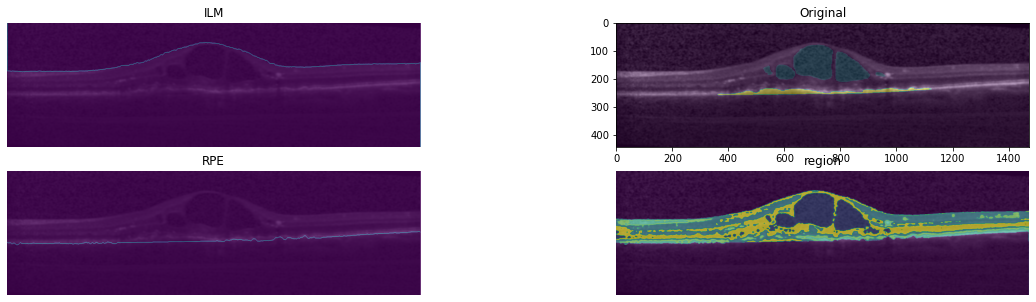

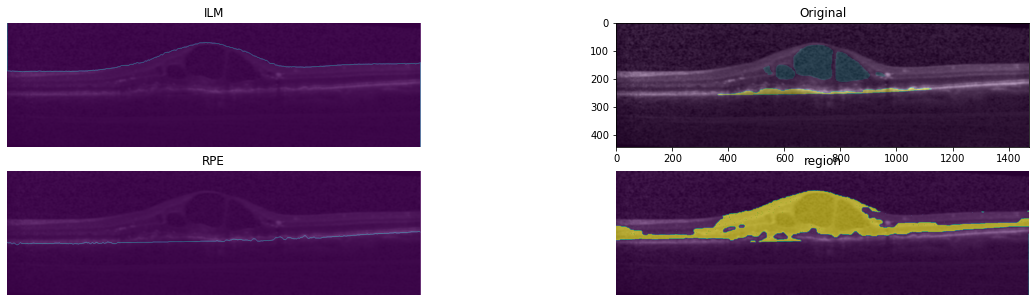

In [31]:
# Image Loading:
manufacturer = 'Spectralis'
for i in range(20,25,5):
    print(i)
    slice_ = i

    itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/TRAIN025/oct.mhd')
    ref_itkimage = sitk.ReadImage(f'../data/RETOUCH-TrainingSet-Spectralis/TRAIN025/reference.mhd')

    oct_scan = sitk.GetArrayFromImage(itkimage)
    ref_oct_scan = sitk.GetArrayFromImage(ref_itkimage)

    # Preprocess:
    # GUARDAR SIZE Y POSICIONES ORIGINALES PARA RECONSTRUIR TAMAÑO ORIGINAL A LA SALIDA
    im, ref = region_extractor(manufacturer, oct_scan[slice_, :, :], ref_oct_scan[slice_, :, :])
    
    spacing = itkimage.GetSpacing()
    im = skimage.transform.rescale(im, (1, spacing[0]/spacing[1]), order=2)
    ref = skimage.transform.rescale(ref, (1, spacing[0]/spacing[1]), order=0)
    
    if manufacturer=='Spectralis':
        cv2.normalize(im, im, 0, 255, cv2.NORM_MINMAX)
        im = im.astype('uint8')
        im = cv2.bilateralFilter(src=im, d=10, sigmaColor=200, sigmaSpace=2)

    # Get the NS tranform
    T, I = ns_mapper_using_complements(im, 10)
    T = skimage.util.invert(T)

    # Get ILM line
    _, _, _, ilm_image = get_ilm_line_paper(im, T, I)
    
    # Get RPE line and flatten()
    _, _, _, _, rpe_image, indices = get_rpe_line(im, T, I, ilm_image)
    new_rpe_image, _, _, _, _, _, _ = rpe_flattening(rpe_image, w=150, tr = 40, n=1, k=101)
    # Probar filtrado más grande y ventana de pixeles ilm más grande
    
    retina_mask = get_retina_mask(ilm_image.copy(), new_rpe_image.copy())
    
    # Neutrosophic transform
    im_NS = Neutrsophic_Image(im)
    _, im_am_be, betaI = alpha_mean_beta_enh(im_NS)
    
    # Kmeans clustering
    result_clust = clustering(im_am_be, retina_mask, 5)
    
    # Sample the seeds
    fluid_seeds, bkg_seeds = select_seeds(im_am_be, result_clust, n_clust=5, FN=500, TN=700)
    
    plots(im, ref, ilm_image, new_rpe_image, result_clust)
    
    # Obtain the regional terms for object and background
    reg_term_obj, R1p_obj, R1p_bkg = regional_term(im_am_be, fluid_seeds, bkg_seeds, I, region='object')
    reg_term_bkg, R1p_obj, R1p_bkg = regional_term(im_am_be, fluid_seeds, bkg_seeds, I, region='bkg')
    
    
    # Obtain the full weigthed graph
    graph_, nodes = get_graph_flow(
        im_am_be, retina_mask, fluid_seeds, bkg_seeds, reg_term_obj,
        reg_term_bkg,  lamda1 = 1e8, lamda2 = 1e8
    )
    
    # USING SCIPY
#     start = time.time()
#     [m,n] = graph_.shape
#     flow = scipy.sparse.csgraph.maximum_flow(graph_, 0, m-1)
#     matching = flow.residual[1:m-1, m-1:2*m-1]
#     print(matching.toarray())
#     print(np.count_nonzero(matching.toarray()))
#     print(time.time() - start)
#     a = np.zeros(retina_mask.shape)
#     pos = np.where(retina_mask[:,:])
#     a[pos[0],pos[1]] = matching.toarray()[:,0]
#     matching.reshape(im_am_be.shape)
    
    # Get mincut
#     G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
#     cut_value, partition = nx.max_flow_min_cost(G, 0, graph_.shape[0]-1)
    start = time.time()
    G = nx.from_scipy_sparse_matrix(graph_, create_using=nx.Graph, edge_attribute='capacity')
    cut_value, partition = nx.minimum_cut(G, 0, graph_.shape[0]-1)
    reachable, non_reachable = partition
    
    segmentation = np.zeros(im_am_be.shape[0] * im_am_be.shape[1])
    obj_nodes = np.array(list(reachable)[1:])-1
    bkg_nodes = np.array(list(reachable)[:-1])-1
    segmentation[nodes[obj_nodes]] = 1
    segmentation = np.reshape(segmentation, (im_am_be.shape))
    
    plots(im, ref, ilm_image, new_rpe_image, segmentation)

### BACKUP